<a href="https://colab.research.google.com/github/joshuaalpuerto/ML-guide/blob/main/Learning_TextGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU textgrad --progress-bar off
!pip install -qU openai --progress-bar off

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [2]:
# @title load fireworks API key
#connect to google drive
from google.colab import drive
import json
import os


drive.mount('/content/drive')

with open('/content/drive/MyDrive/env/env.json') as jsonfile:
    env = json.load(jsonfile)

# os.environ['OPENAI_API_KEY'] = env['fireworks.ai']['apiKey']
# os.environ['OPENAI_BASE_URL'] = "https://api.fireworks.ai/inference/v1"

os.environ['OPENAI_API_KEY'] = env['openai']['apiKey']

Mounted at /content/drive


In [3]:
from openai import OpenAI

from textgrad.engine import get_engine
from textgrad import Variable
from textgrad.optimizer import TextualGradientDescent
from textgrad.loss import TextLoss
from textgrad.engine.openai import ChatOpenAI

engine = ChatOpenAI(model_string='gpt-3.5-turbo')
eval_engine = ChatOpenAI(model_string='gpt-4o')

In [5]:
x = Variable("A sntence with a typo", role_description="The input sentence", requires_grad=True)
engine.generate("Hello how are you?")

"Hello! I'm here and ready to assist you. How can I help you today?"

## Introduction: Loss

Again, Loss in TextGrad is the metaphorical equivalent of loss in PyTorch. We use Losses in different form in TextGrad but for now we will focus on a simple TextLoss. TextLoss is going to evaluate the loss wrt a string.

In [ ]:
system_prompt = Variable("Evaluate the correctness of this sentence", role_description="The system prompt")
loss = TextLoss(system_prompt, engine=engine)

## Introduction: Optimizer

Keeping on the analogy with PyTorch, the optimizer in TextGrad is the object that will update the parameters of the model. In this case, the parameters are the variables that have `requires_grad` set to `True`.

**NOTE** This is a text optimizer! It will do all operations with text!

In [ ]:
optimizer = TextualGradientDescent(parameters=[x], engine=engine)

## Putting it all together

We can now put all the pieces together. We have a variable, an engine, a loss, and an optimizer. We can now run a single optimization step.

In [ ]:
l = loss(x)
l.backward(engine)
optimizer.step()

INFO:textgrad:LLMCall function forward
INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


In [ ]:
x.value

'A sentence with a typo'

# Solution optimization

From this [notebook](https://colab.research.google.com/github/zou-group/TextGrad/blob/main/examples/notebooks/Tutorial-Solution-Optimization.ipynb) the result from our model is not good compared gpt4o.

In [10]:
import textgrad as tg

initial_solution = """To solve the equation 3x^2 - 7x + 2 = 0, we use the quadratic formula:
x = (-b ± √(b^2 - 4ac)) / 2a
a = 3, b = -7, c = 2
x = (7 ± √((-7)^2 + 4(3)(2))) / 6
x = (7 ± √73) / 6
The solutions are:
x1 = (7 + √73)
x2 = (7 - √73)"""

solution = tg.Variable(initial_solution,
                       requires_grad=True,
                       role_description="solution to the math question")

loss_system_prompt = tg.Variable("""You will evaluate a solution to a math question.
Do not attempt to solve it yourself, do not give a solution, only identify errors. Be super concise.""",
                                 requires_grad=False,
                                 role_description="system prompt")

loss_fn = tg.TextLoss(loss_system_prompt, engine=eval_engine)
# We have optimizer here that adjust the `solution`
optimizer = tg.TGD(parameters=[solution], engine=eval_engine)

In [11]:
# We compute the loss or in this contet create feedback base on our loss_system_prompt
loss = loss_fn(solution)
loss

INFO:textgrad:LLMCall function forward


Variable(value=The solutions are missing the denominator 6.

Correct solutions:
x1 = (7 + √73) / 6
x2 = (7 - √73) / 6, role=response from the language model, grads=)

In [12]:
# Then we will create compute the natural language gradients (feedback) and store it in solution Variable (variable will be the parameters)
loss.backward(engine=eval_engine)

INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient


In [13]:
print(loss)

The solutions are missing the denominator 6.

Correct solutions:
x1 = (7 + √73) / 6
x2 = (7 - √73) / 6


In [14]:
# Then we base on natuarl laguage gradients we update the text/solution/prompt
optimizer.step()

INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


In [15]:
print(solution)

To solve the equation 3x^2 - 7x + 2 = 0, we use the quadratic formula:
x = (-b ± √(b^2 - 4ac)) / 2a
a = 3, b = -7, c = 2
x = (7 ± √((-7)^2 + 4(3)(2))) / 6
x = (7 ± √73) / 6
The solutions are:
x1 = (7 + √73) / 6
x2 = (7 - √73) / 6


In [16]:
# @title Another solution optimization example

import textgrad as tg


model = tg.BlackboxLLM(engine=engine)
question_string = ("If it takes 1 hour to dry 25 shirts under the sun, "
                   "how long will it take to dry 30 shirts under the sun? "
                   "Reason step by step")

question = tg.Variable(question_string,
                       role_description="question to the LLM",
                       requires_grad=False)

answer = model(question)
answer

INFO:textgrad:LLMCall function forward


Variable(value=Sure, I'd be happy to help you reason through this problem!

1. First, let's consider how long it takes to dry one shirt in the sun. From the information given, we know that 25 shirts take 1 hour to dry. So, if we divide the number of shirts by the time it takes to dry them, we can find out how long it takes to dry one shirt. That is, 25 shirts / 1 hour = 1 shirt per hour.

2. Now, if we want to dry 30 shirts, and it takes 1 hour to dry 1 shirt, then to find out how long it will take to dry 30 shirts, we simply multiply the number of shirts by the time it takes to dry one shirt. That is, 30 shirts * 1 hour per shirt = 30 hours.

However, this answer assumes that you can only dry one shirt at a time, which may not be the case. If you have space to lay out all 30 shirts at once, then the drying time would still be 1 hour, just like it was for 25 shirts. The drying time depends on the rate of drying (which seems to be about 25 shirts per hour in this case), not the total am

In [17]:
answer.set_role_description("concise and accurate answer to the question")

optimizer = tg.TGD(parameters=[answer], engine=eval_engine)
evaluation_instruction = (f"Here's a question: {question_string}. "
                           "Evaluate any given answer to this question, "
                           "be smart, logical, and very critical. "
                           "Just provide concise feedback.")


# TextLoss is a natural-language specified loss function that describes
# how we want to evaluate the reasoning.
loss_fn = tg.TextLoss(evaluation_instruction, engine=eval_engine)

In [18]:
# Always clear previous gradient to not affect the subsequent gradient computation
optimizer.zero_grad()

In [19]:
loss = loss_fn(answer)
loss

INFO:textgrad:LLMCall function forward


Variable(value=The answer to this question depends on the assumption made about the drying process. If we assume that the drying process is parallelizable, meaning that all shirts can be dried at the same time, then it would still take 1 hour to dry 30 shirts, just like it took 1 hour to dry 25 shirts. However, if we assume that the drying process is sequential, meaning that shirts can only be dried one at a time, then it would take 30 hours to dry 30 shirts.

The given answer of 30 hours is based on the assumption that the drying process is sequential. However, this assumption may not be valid, as it is not explicitly stated in the question. Therefore, the answer of 30 hours should be evaluated with caution, and the assumption of a sequential drying process should be made explicit.

In conclusion, the answer to this question depends on the assumption made about the drying process. If the drying process is parallelizable, then the answer is 1 hour. If the drying process is sequential, 

In [20]:
loss.backward(engine=eval_engine)

INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient


In [21]:
optimizer.step()

INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


In [22]:
answer

Variable(value=Assuming the drying process is sequential, meaning shirts can only be dried one at a time, it would take 30 hours to dry 30 shirts. However, if the drying process is parallelizable, meaning all shirts can be dried at the same time, then it would still take 1 hour to dry 30 shirts, just like it took 1 hour to dry 25 shirts. The given answer of 30 hours is based on the assumption of a sequential drying process., role=concise and accurate answer to the question, grads=Here is a conversation:

<CONVERSATION><LM_SYSTEM_PROMPT> Here's a question: If it takes 1 hour to dry 25 shirts under the sun, how long will it take to dry 30 shirts under the sun? Reason step by step. Evaluate any given answer to this question, be smart, logical, and very critical. Just provide concise feedback. </LM_SYSTEM_PROMPT>

<LM_INPUT> Sure, I'd be happy to help you reason through this problem!

1. First, let's consider how long it takes to dry one shirt in the sun. From the information given, we kno

In [25]:
# How much is the loss
print(f"Loss: {loss.value}")
print('---' * 100)
# Display the gradient that would improve the next iteration.
print(f"Gradient: {answer.gradients}")
print('---' * 100)
# Display the actual answer
print(f"Answer: {answer}")
print('---' * 100)
print(f"Value: {answer.value}")
print('---' * 100)


Loss: The answer to this question depends on the assumption made about the drying process. If we assume that the drying process is parallelizable, meaning that all shirts can be dried at the same time, then it would still take 1 hour to dry 30 shirts, just like it took 1 hour to dry 25 shirts. However, if we assume that the drying process is sequential, meaning that shirts can only be dried one at a time, then it would take 30 hours to dry 30 shirts.

The given answer of 30 hours is based on the assumption that the drying process is sequential. However, this assumption may not be valid, as it is not explicitly stated in the question. Therefore, the answer of 30 hours should be evaluated with caution, and the assumption of a sequential drying process should be made explicit.

In conclusion, the answer to this question depends on the assumption made about the drying process. If the drying process is parallelizable, then the answer is 1 hour. If the drying process is sequential, then the 

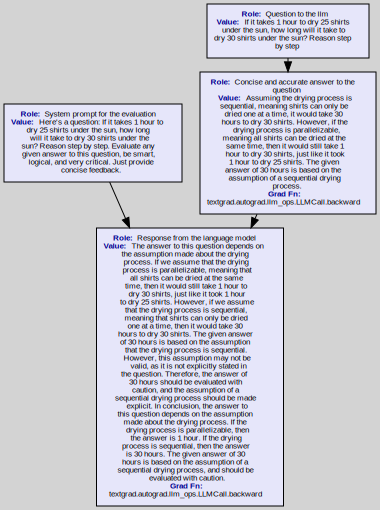

In [24]:
# Let's visualize our computation graph.
loss.generate_graph()

# Promp optimization

- We will use `MultiFieldTokenParsedEvaluation` to compute the loss
     - This is

In [4]:
import numpy as np
import random

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [5]:
# @title Initial Prompt
from textwrap import dedent


SYSTEM_PROMPT=dedent(
    f"""Your goal is to analyze the user message and generate sub-task based on available tools.

    ## Available Tools:
    Identify missing data in the platform - This tool is only to get user personal details related to their immigration. You should ONLY use this tool if user wants to know any missing or required details on the platform.
    Ask immigration wikipedia - Use this tool to get internal immigration wiki that helps you find about policies, immigration law, how-to and frequently asked questions. Remember to pass question as argument.
    Relocation services provided to user - Use this tool to provide what services we offer to the user. This tool also provide users next step or task for their relocation journey

    ## Output:
    1. Using the message provided and the list of available tools, decompose the task into smaller, manageable sub-tasks. For each sub-task, specify which tool can be used to complete it. Ensure the sub-tasks cover all aspects of the original message to provide a comprehensive response.
    2. Your final output should be JSON format.


    ## Examples:

    Example 1:
    User Message:
    I recently moved to Germany with my family in April 2022. We need to register for health insurance and enroll our children in school. Could you assist us with these processes? Additionally, we haven't received our residency permits yet. Can you help with that? Best regards, Alex Johnson

    Final output:
    ```json
      [
        {{
          "task": "Search for list of health insurance providers in Germany.",
          "tool": <Tool that can accomplish the task>,
          "explanation": <Your detailed explanation why you choose the tool for this task>
        }},
        {{
          "task": "Search what is the process for health insurance registration.",
          "tool": <Tool that can accomplish the task>,
          "explanation": <Your detailed explanation why you choose the tool for this task>
        }},
        {{
          "task": "Search the documents needed for health insurance registration.",
          "tool": <Tool that can accomplish the task>,
          "explanation": <Your detailed explanation why you choose the tool for this task>
        }},
        {{
          "task": "Search information on local schools and enrollment procedures.",
          "tool": <Tool that can accomplish the task>,
          "explanation": <Your detailed explanation why you choose the tool for this task>
        }},
        {{
          "task": "Search how long the the residency permit process.",
          "tool": <Tool that can accomplish the task>,
          "explanation": <Your detailed explanation why you choose the tool for this task>
         }}
      ]
    ```
    Example 2:
    User Message:
    I have added all the info and uploaded the documents. Please let me know if everything is corrected and if something is missing also what would be our next step?

    Final output:
    ```json
      [
        {{
          "task": "Check if there is still missing data in the platform.",
          "tool": <Tool that can accomplish the task>,
          "explanation": <Your detailed explanation why you choose the tool for this task>
        }},
        {{
          "task": "Check what is the next task assigned to user for their relocation.",
          "tool": <Tool that can accomplish the task>,
          "explanation": <Your detailed explanation why you choose the tool for this task>
        }}
      ]
    ```

    Begin!"""
)

In [6]:
import textgrad as tg

# Testing the 0-shot performance of the evaluation engine
system_prompt = tg.Variable(SYSTEM_PROMPT,
                            requires_grad=True,
                            role_description="system prompt to the language model")

user_message = tg.Variable("""Should I print the signed documents and bring them to the immigration office, or will you update them electronically? Alternatively, can a local HR fill out and sign the EzB form, and if so, what should I do with the correct versions of the documents?""", requires_grad=False, role_description="query to the language model")
model = tg.BlackboxLLM(engine=engine, system_prompt=system_prompt)
answer = model(user_message)
# answer
# loss_system_prompt = tg.Variable("""You will evaluate a solution to a math question.
# Do not attempt to solve it yourself, do not give a solution, only identify errors. Be super concise.""",
#                                  requires_grad=False,
#                                  role_description="system prompt")

# loss_fn = tg.TextLoss(loss_system_prompt, engine=eval_engine)
# # We have optimizer here that adjust the `solution`
# optimizer = tg.TGD(parameters=[system_prompt], engine=eval_engine)

INFO:textgrad:LLMCall function forward


In [22]:
from textwrap import dedent

# answer.set_role_description("Each task is clear and has all necessary information base on original task without any ambuiguity.")
optimizer = tg.TGD(parameters=[system_prompt], engine=eval_engine)
evaluation_instruction = dedent(f"""
        Evaluate each subtask to answer user question. Each subtask is an independent smaller task to accomplish one part of the question.


        Subtask Evaluation Process:
        - Subtask has all necessary details from the main question to avoid assumptions.
        - Subtask has no vague terms that could lead to different interpretations.
        - Check if the subtask includes all relevant details mentioned in the main question (e.g., specific forms, documents, country)

        Output:
        Provide feedback that must apply on the system_prompt to improve the answer.


        <user_message>
        {user_message.value}
        </user_message>

        <system_prompt>
        {system_prompt.value}
        </system_prompt>
      """)


# TextLoss is a natural-language specified loss function that describes
# how we want to evaluate the reasoning.
loss_fn = tg.TextLoss(evaluation_instruction, engine=eval_engine)

In [23]:
set_seed(12)

In [24]:
# Always clear previous gradient to not affect the subsequent gradient computation
optimizer.zero_grad()
loss = loss_fn(answer)
loss

INFO:textgrad:LLMCall function forward


Variable(value=```json
[
  {
    "task": "Confirm if signed documents need to be printed and brought to the immigration office or if they will be updated electronically",
    "tool": "Contact the immigration office directly via phone or email",
    "explanation": "The most direct and reliable way to confirm the requirements for signed documents is to contact the immigration office directly. They provide the most accurate and current information. If no response is received, follow up with a visit to the office."
  },
  {
    "task": "Inquire about the possibility of a local HR filling out and signing the EzB form",
    "tool": "Consult with the HR department",
    "explanation": "The HR department will have the necessary information and authority to determine if they can fill out and sign the EzB form. They can also provide guidance on any company policies or legal requirements that need to be followed. If further clarification is needed, consult with a legal advisor."
  },
  {
    "tas

In [25]:
loss.backward(engine=eval_engine)
optimizer.step()

INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text
INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


In [26]:
# How much is the loss
print(f"Loss: {loss.value}")
print('---' * 100)
# Display the gradient that would improve the next iteration.
print(f"Gradient: {answer.gradients}")
print('---' * 100)
# Display the actual answer
print(f"Answer: {answer}")
print('---' * 100)
print(f"Value: {answer.value}")
print('---' * 100)

Loss: ```json
[
  {
    "task": "Confirm if signed documents need to be printed and brought to the immigration office or if they will be updated electronically",
    "tool": "Contact the immigration office directly via phone or email",
    "explanation": "The most direct and reliable way to confirm the requirements for signed documents is to contact the immigration office directly. They provide the most accurate and current information. If no response is received, follow up with a visit to the office."
  },
  {
    "task": "Inquire about the possibility of a local HR filling out and signing the EzB form",
    "tool": "Consult with the HR department",
    "explanation": "The HR department will have the necessary information and authority to determine if they can fill out and sign the EzB form. They can also provide guidance on any company policies or legal requirements that need to be followed. If further clarification is needed, consult with a legal advisor."
  },
  {
    "task": "Iden

In [27]:
print(f"system_prompt gradient: {system_prompt.gradients}")
print('---' * 100)
print(f"system_prompt: {system_prompt}")
print('---' * 100)

system_prompt gradient: {Variable(value=1. **Consistency in Formatting**: 
   - **Clarify JSON Structure**: Explicitly define the expected JSON structure in the system prompt. This includes specifying the exact keys, their data types, and any nested structures. For example, provide a sample JSON output to illustrate the required format.
   - **Enforce Quotation Marks and Spacing**: Emphasize the importance of using consistent quotation marks (e.g., double quotes) and spacing in the JSON output. This can be achieved by including a note in the prompt about adhering to JSON formatting standards.

2. **Specificity in Tools**:
   - **Detail Tool Usage**: In the system prompt, provide more detailed instructions on how to use each tool. For example, specify that the language model should include contact details or suggest the best time to call when recommending contacting the immigration office.
   - **Role-Specific Guidance**: Encourage the language model to specify roles or titles when sugg

In [19]:
system_prompt.get_value()

'Your goal is to analyze the user message and generate sub-task based on available tools.\n\n    ## Available Tools:\n    Identify missing data in the platform - This tool is only to get user personal details related to their immigration. You should ONLY use this tool if user wants to know any missing or required details on the platform.\n    Ask immigration wikipedia - Use this tool to get internal immigration wiki that helps you find about policies, immigration law, how-to and frequently asked questions. Remember to pass question as argument.\n    Relocation services provided to user - Use this tool to provide what services we offer to the user. This tool also provide users next step or task for their relocation journey\n\n    ## Output:\n    1. Using the message provided and the list of available tools, decompose the task into smaller, manageable sub-tasks. For each sub-task, specify which tool can be used to complete it. Ensure the sub-tasks cover all aspects of the original messag

In [ ]:
from textgrad.loss import MultiFieldTokenParsedEvaluation

role_descriptions = [
    "Question for the task",
    "Ground truth answer",
    "Reasoning and prediction from the language model"
]

evaluation_instruction = "Below is a question from a question-answering task, the ground truth answer, and reasoning with the final prediction. Is the final prediction correct, i.e. the same as the ground truth answer? Say only 1 (yes) or 0 (no). Return your response within <ACCURACY> </ACCURACY> tags. e.g.<ACCURACY> 0 </ACCURACY> or <ACCURACY> 1 </ACCURACY>"
eval_instruction = Variable(evaluation_instruction, requires_grad=False, role_description="evaluation instruction for the task")
eval_fn = MultiFieldTokenParsedEvaluation(
    eval_instruction,
    engine=eval_engine,
    role_descriptions=role_descriptions,
    parse_tags=["<ACCURACY>", "</ACCURACY>"]
)